# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as pltq

import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package punkt to /Users/yash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/yash/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yash/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load in training data and display in pandas dataframe
train_path='/Users/yash/Desktop/NLP/Assignment 2/training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='/Users/yash/Desktop/NLP/Assignment 2/test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

Episode  Scene                   Scene_info Character_name  \
0         1350      1  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1         1350      1  DESERTED CAR PARK EXT NIGHT          OTHER   
2         1350      2                R&R INT NIGHT           JACK   
3         1350      2                R&R INT NIGHT         RONNIE   
4         1350      2                R&R INT NIGHT           JACK   
...        ...    ...                          ...            ...   
15314     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15315     1399     55         SQUARE EXT DAY LIGHT            MAX   
15316     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15317     1399     55         SQUARE EXT DAY LIGHT            MAX   
15318     1399     55         SQUARE EXT DAY LIGHT          OTHER   

                                                                                                              Line  \
0                                               Look at ya, not a mark on ya. And you think you're an unlucky man.   
1                                                                                                         Shirl...   
2                                                         Oi. Where have you been? Huh? What were the texts about?   
3                                                          Nothing. Nothing. I'll be with you in two minutes yeah?   
4            Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.   
...                                                                                                            ...   
15314  Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.   
15315                                                   Thanks Bradley. Thanks mate... It means the world to me...   
15316                                                                                               You alright...   
15317                                                                                  Yeah, yeah, yeah. I'm fine.   
15318                                                                                           Well, let me know.   

       Gender  
0      FEMALE  
1        MALE  
2        MALE  
3      FEMALE  
4        MALE  
...       ...  
15314    MALE  
15315    MALE  
15316    MALE  
15317    MALE  
15318    MALE  

[15319 rows x 6 columns]

In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
#from random import shuffle
from random import shuffle,seed
seed(0)
epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = list(set([x for x in epsiode_scene_column.values]))
shuffle(episode_scenes)
print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)
all_train_data

1394
1254 140


Episode  Scene                   Scene_info Character_name  \
0         1350      1  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1         1350      1  DESERTED CAR PARK EXT NIGHT          OTHER   
2         1350      2                R&R INT NIGHT           JACK   
3         1350      2                R&R INT NIGHT         RONNIE   
4         1350      2                R&R INT NIGHT           JACK   
...        ...    ...                          ...            ...   
15314     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15315     1399     55         SQUARE EXT DAY LIGHT            MAX   
15316     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15317     1399     55         SQUARE EXT DAY LIGHT            MAX   
15318     1399     55         SQUARE EXT DAY LIGHT          OTHER   

                                                                                                              Line  \
0                                               Look at ya, not a mark on ya. And you think you're an unlucky man.   
1                                                                                                         Shirl...   
2                                                         Oi. Where have you been? Huh? What were the texts about?   
3                                                          Nothing. Nothing. I'll be with you in two minutes yeah?   
4            Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.   
...                                                                                                            ...   
15314  Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.   
15315                                                   Thanks Bradley. Thanks mate... It means the world to me...   
15316                                                                                               You alright...   
15317                                                                                  Yeah, yeah, yeah. I'm fine.   
15318                                                                                           Well, let me know.   

       Gender episode_scene train_heldout  
0      FEMALE        1350-1      training  
1        MALE        1350-1      training  
2        MALE        1350-2      training  
3      FEMALE        1350-2      training  
4        MALE        1350-2      training  
...       ...           ...           ...  
15314    MALE       1399-55      training  
15315    MALE       1399-55      training  
15316    MALE       1399-55      training  
15317    MALE       1399-55      training  
15318    MALE       1399-55      training  

[15319 rows x 8 columns]

In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13675, 8)
Validation set:  (1644, 8)


In [5]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.5 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [6]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [7]:
create_character_document_from_dataframe(train_data,360)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 345, 'CLARE': 360}


{'SHIRLEY': 'Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ No you\'re not, ssh, shut up. _EOL_ Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ Kevin. Kevin! _EOL_ Kevin I\'m gonna go to the main road - _EOL_ To make sure they know where to go. _EOL_ Kevin I\'ll be five minutes. _EOL_ You\'ll be fine. You\'re talking. I\'ll be five minutes. _EOL_ It\'s alright, it\'s alright, it\'s alright, it\'s alright. _EOL_ Go away. _EOL_ I don\'t know what to say. It\'s a nightmare. _EOL_ He asked me to go with him. _EOL_ Yeah. _EOL_ Between us? Of course not. _EOL

In [8]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 345, 'CLARE': 360}
Num. Characters:  16 

SHIRLEY Number of Words:  3923
OTHER Number of Words:  3128
JACK Number of Words:  3938
RONNIE Number of Words:  3530
TANYA Number of Words:  3789
SEAN Number of Words:  3708
ROXY Number of Words:  3727
HEATHER Number of Words:  4062
MAX Number of Words:  4613
IAN Number of Words:  4453
JANE Number of Words:  3664
STACEY Number of Words:  3963
PHIL Number of Words:  3671
MINTY Number of Words:  3941
CHRISTIAN Number of Words:  3793
CLARE Number of Words:  4392
total words 62295


In [9]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [10]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
train_labels

['CHRISTIAN',
 'CLARE',
 'HEATHER',
 'IAN',
 'JACK',
 'JANE',
 'MAX',
 'MINTY',
 'OTHER',
 'PHIL',
 'RONNIE',
 'ROXY',
 'SEAN',
 'SHIRLEY',
 'STACEY',
 'TANYA']

In [11]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [177]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [13]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20703 stored elements in Compressed Sparse Row format>

In [14]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'OTHER': 40, 'ROXY': 40, 'RONNIE': 40, 'TANYA': 40, 'SHIRLEY': 40, 'JANE': 40, 'JACK': 40, 'PHIL': 40, 'MAX': 40, 'IAN': 40, 'STACEY': 40, 'SEAN': 40, 'HEATHER': 40, 'MINTY': 30, 'CHRISTIAN': 40, 'CLARE': 28}
Num. Characters:  16 

OTHER Num of Words:  480
ROXY Num of Words:  473
RONNIE Num of Words:  358
TANYA Num of Words:  429
SHIRLEY Num of Words:  271
JANE Num of Words:  423
JACK Num of Words:  841
PHIL Num of Words:  450
MAX Num of Words:  516
IAN Num of Words:  403
STACEY Num of Words:  327
SEAN Num of Words:  334
HEATHER Num of Words:  448
MINTY Num of Words:  397
CHRISTIAN Num of Words:  457
CLARE Num of Words:  312
total words 6919


In [15]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [16]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3570 stored elements in Compressed Sparse Row format>

In [17]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [18]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [19]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    import matplotlib.pyplot as plt
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [20]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.5625
mean cosine similarity 0.9048794876433548
3 correct out of 16 / accuracy: 0.1875


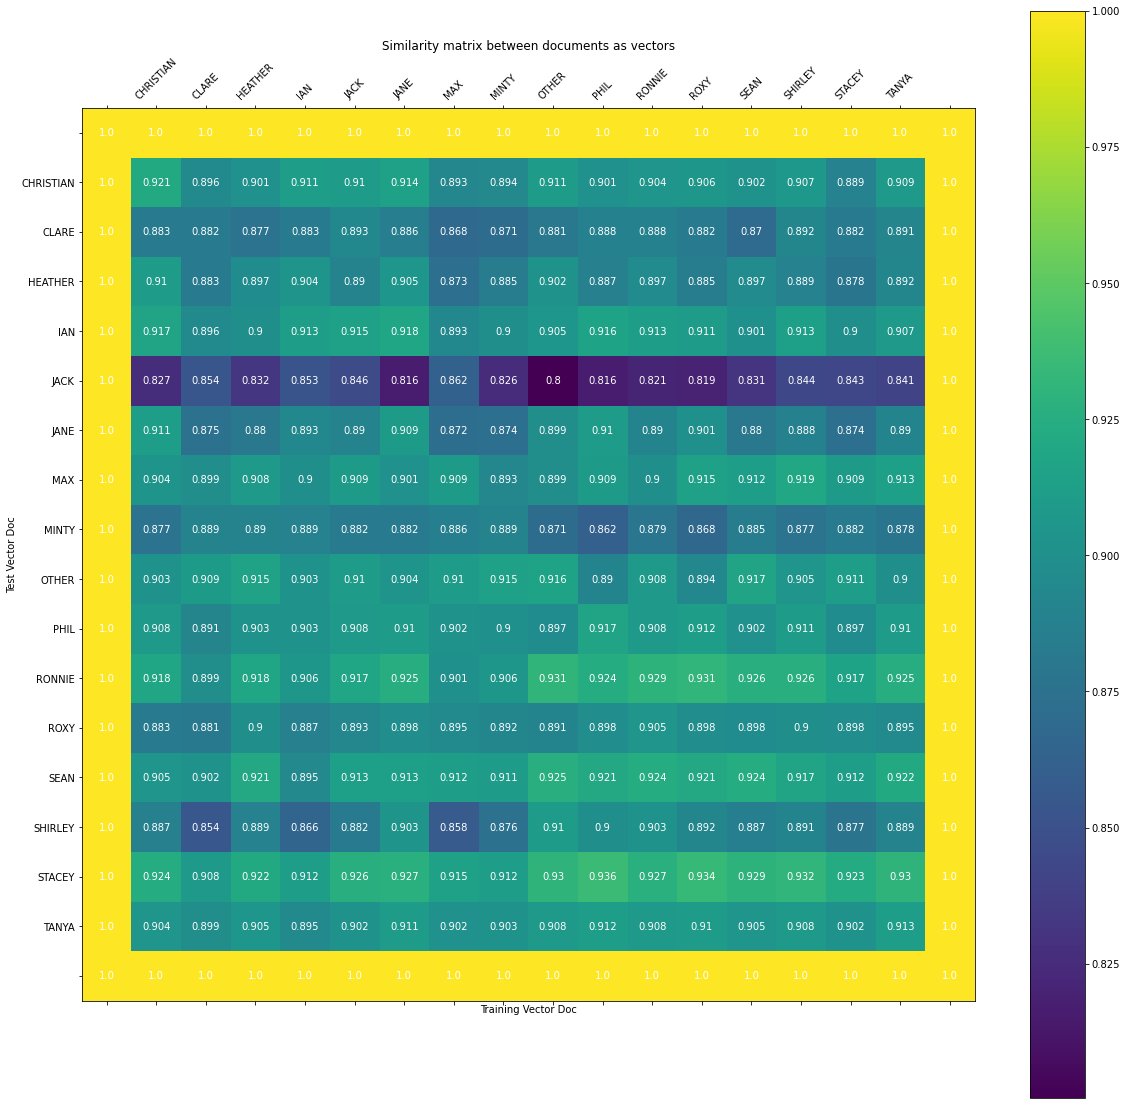

In [21]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

# ------------------------------------------------------------------------------------------

# ANSWER 1

## Creating a new pre_process function with Tokenization,Stemming,Lemmatization,Punctuation and Stop Word Removal and checking the new cosine similarity

In [178]:
p_stemmer = PorterStemmer()
import spacy 
clean_dat = spacy.load("en_core_web_sm")
def pre_process_q1(text):
        #Tokenization

    tokens = word_tokenize(text)

    tokens = [i for i in tokens if i.isalpha()]
    
    #Stemming
    # nltk_stemedList = []
    # for word in nltk_tokenList:
    #     nltk_stemedList.append(p_stemmer.stem(word))

    #Remove stopword
    filtered_sentence = []  
    spacy_stop_words = clean_dat.Defaults.stop_words
    for w in tokens:  
        if w.lower() not in spacy_stop_words:  
            filtered_sentence.append(w)
            
    #Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in filtered_sentence:
        nltk_lemmaList.append(wordnet_lemmatizer.lemmatize(word))

    
    print(nltk_lemmaList)
    return nltk_lemmaList

## creating a training corpus and extracting labels 

In [179]:
# create list of pairs of (character name, pre-processed character) 
training_corpus_q1 = [(name, pre_process_q1(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels_q1 = [name for name, doc in training_corpus]

['Lesley', 'glad', 'Ian', 'partner', 'Ashley', 'lovely', 'little', 'place', 'seen', 'flesh', 'Ashley', 'Lesley', 'compare', 'way', 'described', 'forgetting', 'Lesley', 'changed', 'therapist', 'bloke', 'indicates', 'attempt', 'run', 'away', 'let', 'thing', 'sister', 'called', 'relationship', 'love', 'hate', 'right', 'Jane', 'Love', 'break', 'heart', 'bottle', 'best', 'champagne', 'start', 'counting', 'penny', 'Jane', 'paying', 'ai', 'Ash', 'know', 'Ian', 'exactly', 'imagined', 'Ash', 'kind', 'bloke', 'Jane', 'end', 'marrying', 'mean', 'David', 'going', 'tough', 'act', 'follow', 'word', 'think', 'found', 'Yeah', 'Ash', 'Hampstead', 'Heath', 'allowed', 'authority', 'dim', 'view', 'probation', 'officer', 'dating', 'client', 'certainly', 'act', 'like', 'probation', 'officer', 'quiet', 'Jane', 'Sorry', 'shut', 'course', 'nervous', 'seen', 'long', 'David', 'die', 'year', 'think', 'kidding', 'like', 'Jane', 'drink', 'took', 'security', 'passion', 'know', 'sure', 'way', 'work', 'day', 'sure', '

## Creating the training data matrix (using the DictVectorizer) from the features that we extracted 

In [180]:
corpusVectorizer = DictVectorizer() 
training_feature_matrix_q1 = create_document_matrix_from_corpus(training_corpus_q1, fitting=True)

## Creating the validation data corpus and extracting labels for the same

In [181]:
# get the validation data- only 40 lines used for each character
val_character_docs_q1 = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs_q1.keys()),"\n")
total_words = 0
for name in val_character_docs_q1.keys():
    print(name, 'Num of Words: ',len(val_character_docs_q1[name].split()))
    total_words += len(val_character_docs_q1[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus_q1 = [(name, pre_process_q1(doc)) for name, doc in sorted(val_character_docs_q1.items())]
val_labels_q1 = [name for name, doc in val_corpus_q1]

lines per character {'OTHER': 40, 'ROXY': 40, 'RONNIE': 40, 'TANYA': 40, 'SHIRLEY': 40, 'JANE': 40, 'JACK': 40, 'PHIL': 40, 'MAX': 40, 'IAN': 40, 'STACEY': 40, 'SEAN': 40, 'HEATHER': 40, 'MINTY': 30, 'CHRISTIAN': 40, 'CLARE': 28}
Num. Characters:  16 

OTHER Num of Words:  480
ROXY Num of Words:  473
RONNIE Num of Words:  358
TANYA Num of Words:  429
SHIRLEY Num of Words:  271
JANE Num of Words:  423
JACK Num of Words:  841
PHIL Num of Words:  450
MAX Num of Words:  516
IAN Num of Words:  403
STACEY Num of Words:  327
SEAN Num of Words:  334
HEATHER Num of Words:  448
MINTY Num of Words:  397
CHRISTIAN Num of Words:  457
CLARE Num of Words:  312
total words 6919
['Ian', 'getting', 'hot', 'collar', 'Bet', 'got', 'rule', 'written', 'Laminated', 'know', 'walk', 'emigrating', 'Wondered', 'kicked', 'round', 'promised', 'Jane', 'bet', 'drink', 'mind', 'sharing', 'sister', 'speaking', 'suppose', 'favour', 'clay', 'drawing', 'impurity', 'Male', 'grooming', 'century', 'Ian', 'Egyptian', 'men', 

## Creating the validation data matrix 

In [182]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix_q1 = create_document_matrix_from_corpus(val_corpus_q1, fitting=False)

## Computing the new mean rank and accuracy using the newly created pre-process function and observing a change

In [183]:
mean_rank_q1, mean_cosine_simliarity_q1, acc_q1, df_q1 = compute_IR_evaluation_scores(training_feature_matrix_q1, val_feature_matrix_q1, train_labels_q1, val_labels_q1)

mean rank 1.25
mean cosine similarity 0.5172694513370323
15 correct out of 16 / accuracy: 0.9375


## Conclusion

### It can be seen that there is a significant amount of change in the mean_rank after using the new pre-processing techniques. The mean rank has decreased from 4.5625 to 1.25. The best combination of these techniques which helped us achieve such a good mean rank involved:-

#### 1)Tokenization
#### 2) Removing all the punctuations using the isaplha function which returns an alphanumeric value for any input
#### 3) Removing the stop words using the spacy library
#### 4) Lemmatization (takes the root or the lemma of the word)

# ANSWER 2

## <em>Our goal for question 2 is to improve the feature extraction by adding meaningful features to our feature vector and observe a change in the mean rank.

## creating a new instance of our training corpus and labels for the question 2 (using the pre-processing function created in question 1)

In [248]:
# create list of pairs of (character name, pre-processed character) 
training_corpus_q2 = [(name, pre_process_q1(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels_q2 = [name for name, doc in training_corpus_q2]

['Lesley', 'glad', 'Ian', 'partner', 'Ashley', 'lovely', 'little', 'place', 'seen', 'flesh', 'Ashley', 'Lesley', 'compare', 'way', 'described', 'forgetting', 'Lesley', 'changed', 'therapist', 'bloke', 'indicates', 'attempt', 'run', 'away', 'let', 'thing', 'sister', 'called', 'relationship', 'love', 'hate', 'right', 'Jane', 'Love', 'break', 'heart', 'bottle', 'best', 'champagne', 'start', 'counting', 'penny', 'Jane', 'paying', 'ai', 'Ash', 'know', 'Ian', 'exactly', 'imagined', 'Ash', 'kind', 'bloke', 'Jane', 'end', 'marrying', 'mean', 'David', 'going', 'tough', 'act', 'follow', 'word', 'think', 'found', 'Yeah', 'Ash', 'Hampstead', 'Heath', 'allowed', 'authority', 'dim', 'view', 'probation', 'officer', 'dating', 'client', 'certainly', 'act', 'like', 'probation', 'officer', 'quiet', 'Jane', 'Sorry', 'shut', 'course', 'nervous', 'seen', 'long', 'David', 'die', 'year', 'think', 'kidding', 'like', 'Jane', 'drink', 'took', 'security', 'passion', 'know', 'sure', 'way', 'work', 'day', 'sure', '

## Adding five novel features to our feature dictionary. 
1) POS (Part-of-Speech) Tags 
Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence. Here I have performed the POS tagging on the sentence level which means that I have provided each sentence as context to extract the part-of-speech tags. The library used to perform the same is "spacy" which we earlier used to remove the stop words in quesrion 1. The feature will be joined using the "+" symbol.
2) Using bi-grams,tri-grams,four-grams (n-grams)
N-grams are nothing but an n-word sequence of words. The n-gram extraction is performed for all the tokenised words in our corpus. The same has been performed using the NLTK library. The feature will be joined using the "+" symbol.

2) Performing Sentiment Analysis (for each sentence)
Bigrams are nothing but a two-word sequence of words. The bigram extraction is performed for all the tokenised words in our corpus. The same has been performed using the NLTK library. The feature will be joined using the "+" symbol.


Similar to the previous approach in the notebook I calculate the counts of this new features POS and n-grmas. This new feature dictionary will contain the bigrams,trigrams,fourgrams and POS tags as the keys and their respective counts as the values. The keys of sentimental analysis features will be the type of sentiment and the values will be the number of sentences.

In [249]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_analysis(character_text):
  
  sentiment_object = SentimentIntensityAnalyzer()
  tokens = word_tokenize(character_text)

  x = ('positive_sentences', 'negative_sentences', 'neutral_sentences')
  y = 0
  sentiment_counts = dict.fromkeys(x,y)

  temp = ""
  for i in tokens:
    if i != "_EOL_":
      temp = temp + " " +i
    else:
      temp1 = sentiment_object.polarity_scores(temp)
      temp = ""
      if temp1["compound"] >= 0.05: ## setting threshold for positive sentiment
        sentiment_counts['positive_sentences'] += 1
      elif temp1["compound"] <= -0.05:
        sentiment_counts['negative_sentences'] += 1 ## setting threshold for negative sentiment
      else:
        sentiment_counts['neutral_sentences'] += 1  ## else neutral sentiment
  
  return sentiment_counts

In [250]:
sentiments = [(name, sentiment_analysis(doc)) for name, doc in sorted(train_character_docs.items())]

In [251]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.util import ngrams
nltk.download('averaged_perceptron_tagger')
def to_feature_vector_dictionary_q2(name, character_doc, extra_features=[]):
  
  # doc = spacy.tokens.doc.Doc(nlp.vocab, words=character_doc)   
  # for name, proc in nlp.pipeline:
  #   doc = proc(doc)
  # pos_tags = [x.pos_ for x in doc] #computing pos tags for each and every word in the lines of the characters
    
  # key_pos = [] #list for the new key values (word+pos)

  # i = 0
  # for key in doc:
  #     key = f'{key}+{pos_tags[i]}'
  #     key_pos.append(key)
  #     i = i+1

  tagger = spacy.load("en_core_web_sm")
  doc = tagger(" ".join(character_doc))
  key_pos = []
  for token in doc:
    key_pos.append(str(token.text) + "+" + str(token.pos_))
        
  counts = Counter(key_pos)
  counts = dict(counts)

  bigrams = ngrams(character_doc, 2)
  for item in bigrams:
      key = f'{item[0]} + {item[1]}'
      if key in counts.keys():
          counts[key] += 1
      else:
          counts[key] = 1
          
  trigrams = ngrams(character_doc, 3)
  for item in trigrams:
      key = f'{item[0]} + {item[1]} + {item[2]}'
      if key in counts.keys():
          counts[key] += 1
      else:
          counts[key] = 1

  fourgrams = ngrams(character_doc, 4)
  for item in fourgrams:
      key = f'{item[0]} + {item[1]} + {item[2]} + {item[3]}'
      if key in counts.keys():
          counts[key] += 1
      else:
          counts[key] = 1
          
  for i in range(len(sentiments)):
    if sentiments[i][0] == name:
      counts.update(sentiments[i][1])
      
  print(counts)    
  return counts

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yash/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Visualizing the feature dictionary

## Transforming the feature dictionary using a Dict vectorizer and creating the training feature matrix with the newly added features

In [252]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary_q2(name, doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary_q2(name, doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix_q2 = create_document_matrix_from_corpus(training_corpus_q2, fitting=True)

{'Lesley+PROPN': 3, 'glad+ADJ': 2, 'Ian+PROPN': 25, 'partner+NOUN': 2, 'Ashley+PROPN': 2, 'lovely+ADJ': 2, 'little+ADJ': 4, 'place+NOUN': 4, 'seen+VERB': 4, 'flesh+NOUN': 1, 'compare+VERB': 1, 'way+NOUN': 6, 'described+VERB': 1, 'forgetting+VERB': 1, 'changed+VERB': 1, 'therapist+NOUN': 1, 'bloke+NOUN': 4, 'indicates+VERB': 1, 'attempt+NOUN': 1, 'run+VERB': 2, 'away+ADV': 3, 'let+VERB': 4, 'thing+NOUN': 7, 'sister+NOUN': 3, 'called+VERB': 2, 'relationship+NOUN': 1, 'love+NOUN': 4, 'hate+VERB': 1, 'right+INTJ': 3, 'Jane+PROPN': 19, 'Love+PROPN': 2, 'break+VERB': 1, 'heart+NOUN': 1, 'bottle+NOUN': 2, 'best+ADJ': 2, 'champagne+NOUN': 1, 'start+NOUN': 2, 'counting+VERB': 1, 'penny+NOUN': 2, 'paying+VERB': 1, 'ai+INTJ': 1, 'Ash+PROPN': 3, 'know+VERB': 11, 'Ian+NOUN': 4, 'exactly+ADV': 3, 'imagined+VERB': 1, 'kind+ADV': 1, 'bloke+VERB': 1, 'end+NOUN': 2, 'marrying+VERB': 1, 'mean+VERB': 6, 'David+PROPN': 3, 'going+VERB': 10, 'tough+ADJ': 1, 'act+NOUN': 2, 'follow+NOUN': 1, 'word+NOUN': 2, 't

## Cresting a new instance of the validation corpus and labels (with new pre_process function) for question 2

In [253]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus_q2 = [(name, pre_process_q1(doc)) for name, doc in sorted(val_character_docs.items())]
sentiments = [(name, sentiment_analysis(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels_q2 = [name for name, doc in val_corpus_q2]

lines per character {'OTHER': 40, 'ROXY': 40, 'RONNIE': 40, 'TANYA': 40, 'SHIRLEY': 40, 'JANE': 40, 'JACK': 40, 'PHIL': 40, 'MAX': 40, 'IAN': 40, 'STACEY': 40, 'SEAN': 40, 'HEATHER': 40, 'MINTY': 30, 'CHRISTIAN': 40, 'CLARE': 28}
Num. Characters:  16 

OTHER Num of Words:  480
ROXY Num of Words:  473
RONNIE Num of Words:  358
TANYA Num of Words:  429
SHIRLEY Num of Words:  271
JANE Num of Words:  423
JACK Num of Words:  841
PHIL Num of Words:  450
MAX Num of Words:  516
IAN Num of Words:  403
STACEY Num of Words:  327
SEAN Num of Words:  334
HEATHER Num of Words:  448
MINTY Num of Words:  397
CHRISTIAN Num of Words:  457
CLARE Num of Words:  312
total words 6919
['Ian', 'getting', 'hot', 'collar', 'Bet', 'got', 'rule', 'written', 'Laminated', 'know', 'walk', 'emigrating', 'Wondered', 'kicked', 'round', 'promised', 'Jane', 'bet', 'drink', 'mind', 'sharing', 'sister', 'speaking', 'suppose', 'favour', 'clay', 'drawing', 'impurity', 'Male', 'grooming', 'century', 'Ian', 'Egyptian', 'men', 

## Creaing the val feature matrix with new features (using the dict vectorizer) 

In [254]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix_q2 = create_document_matrix_from_corpus(val_corpus_q2, fitting=False)

{'Ian+NOUN': 1, 'getting+VERB': 1, 'hot+ADJ': 1, 'collar+NOUN': 1, 'Bet+PROPN': 1, 'got+VERB': 2, 'rule+NOUN': 1, 'written+VERB': 1, 'Laminated+PROPN': 1, 'know+VERB': 1, 'walk+NOUN': 1, 'emigrating+VERB': 1, 'Wondered+PROPN': 1, 'kicked+VERB': 1, 'round+NOUN': 1, 'promised+VERB': 1, 'Jane+PROPN': 2, 'bet+NOUN': 1, 'drink+NOUN': 1, 'mind+NOUN': 1, 'sharing+VERB': 1, 'sister+NOUN': 1, 'speaking+VERB': 1, 'suppose+VERB': 1, 'favour+NOUN': 1, 'clay+NOUN': 1, 'drawing+NOUN': 1, 'impurity+NOUN': 1, 'Male+ADJ': 1, 'grooming+VERB': 1, 'century+NOUN': 1, 'Ian+PROPN': 3, 'Egyptian+ADJ': 1, 'men+NOUN': 1, 'wore+VERB': 1, 'Romans+PROPN': 1, 'dyed+VERB': 1, 'hair+NOUN': 1, 'bath+NOUN': 1, 'want+VERB': 1, 'help+NOUN': 1, 'wish+VERB': 1, 'continue+VERB': 1, 'walking+VERB': 1, 'earth+NOUN': 1, 'dirty+NOUN': 1, 'unscrubbed+ADJ': 1, 'hairy+ADJ': 1, 'strictly+ADV': 1, 'monochromatic+ADJ': 1, 'colour+NOUN': 1, 'crew+NOUN': 1, 'neck+NOUN': 1, 'Skinny+PROPN': 1, 'jean+NOUN': 1, 'pushing+VERB': 1, 'born+VER

## Computing the new mean rank

In [255]:
mean_rank_q2, mean_cosine_simliarity_q2, acc_q2, df_q2 = compute_IR_evaluation_scores(training_feature_matrix_q2, val_feature_matrix_q2, train_labels_q2, val_labels_q2)

mean rank 2.9375
mean cosine similarity 0.8285015289006532
7 correct out of 16 / accuracy: 0.4375


## Conclusion 

### The mean rank after adding these five new features and computing its counts has increased by a considerable margin i.e., from 1.25 it became 2.9375. The features, POS tags, bigrams, tri-grams, four grams and sentiment analysis were added to improve the context and in turn improve the mean rank but it was observed that it degraded the performance. Therefore, in the next question we have adopted a new approach where we work with context on the sentence level instead of word level.

# Answer 3

### In the 3rd question we have have changed our approach by working on the sentence level instead of word level.
### Untill now we used the pre-process function which removed stop words, tokenized the word and lemmatized them but in this appraoch we are going to add context for each line. We will add the previous sentences and the next sentecnes as a new column in our dataframe and add context tags (pre,post,current) along with pos tags for each words during the pre_processing

### This will add the previous and next lines with the current lines as a column into the dataframe. The previous lines will have the have the key "PRE", the next line will have the key "POST" and the current line will have the key "CURRENT". If the previous or the post lines are from the same speaker then we use the key for that line as "None".

In [100]:
def get_context_train_data(new_train_data):
  """
  Calculates the previous and post context for each user
  """
  new_train_data["context"] = ""
  final_dataframe = pd.DataFrame()
  episode_scene_list = new_train_data['episode_scene'].unique()
  print(len(episode_scene_list))
  for epi_scene in episode_scene_list:
    tempdf = new_train_data[new_train_data['episode_scene'] == epi_scene]
    tempdf.reset_index(inplace=True, drop=True)
    for index, rows in tempdf.iterrows():    
      if  index == 0 and index == tempdf.index[-1]:
        tempdf.at[index,'context'] = {"PRE": "None", "CURRENT" : str(rows['Line']), "POST": "None"}
      elif index == 0 and index != tempdf.index[-1]:
        if tempdf.iloc[index+1]['Character_name'] != rows['Character_name']:
          tempdf.at[index,'context'] = {"PRE": "None", "CURRENT": str(rows['Line']), "POST ":str(tempdf.iloc[index+1]['Line'])}
        else:
          tempdf.at[index,'context'] = {"PRE": "None", "CURRENT": str(rows['Line']), "POST ":"None"}
      elif index != tempdf.index[-1]:
        if (tempdf.iloc[index-1]['Character_name'] == rows['Character_name']) and (tempdf.iloc[index+1]['Character_name'] == rows['Character_name']):
          tempdf.at[index,'context'] = {"PRE": "None", "CURRENT": str(rows['Line']), "POST": "None"}
        elif (tempdf.iloc[index-1]['Character_name'] == rows['Character_name']) and (tempdf.iloc[index+1]['Character_name'] != rows['Character_name']):
          tempdf.at[index,'context'] = {"PRE": "None", "CURRENT": str(rows['Line']), "POST": str(tempdf.iloc[index+1]['Line'])}
        elif (tempdf.iloc[index-1]['Character_name'] != rows['Character_name']) and (tempdf.iloc[index+1]['Character_name'] == rows['Character_name']):
          tempdf.at[index,'context'] = {"PRE": str(tempdf.iloc[index-1]['Line']), "CURRENT": str(rows['Line']), "POST": "None"}
        else:
          tempdf.at[index,'context'] = {"PRE": str(tempdf.iloc[index-1]['Line']), "CURRENT": str(rows['Line']), "POST": str(tempdf.iloc[index+1]['Line'])}
      else:
        if tempdf.iloc[index-1]['Character_name'] != rows['Character_name']:
          tempdf.at[index,'context'] = {"PRE": str(tempdf.iloc[index-1]['Line']), "CURRENT": str(rows['Line']), "POST": "None"}
        else:
          tempdf.at[index,'context'] = {"PRE": "None", "CURRENT": str(rows['Line']), "POST ":"None"}
    
    final_dataframe = final_dataframe.append(tempdf, ignore_index=True)

  return final_dataframe

### Creating new instances of train and test data with added context

In [101]:
train_data_q3 = get_context_train_data(train_data)
val_data_q3 = get_context_train_data(val_data)
train_data_q3

/var/folders/s6/47fk1ktx7k7gg86hmftq997w0000gn/T/ipykernel_47682/428949296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_data["context"] = ""


1254
140


Episode  Scene                   Scene_info Character_name  \
0         1350      1  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1         1350      1  DESERTED CAR PARK EXT NIGHT          OTHER   
2         1350      2                R&R INT NIGHT           JACK   
3         1350      2                R&R INT NIGHT         RONNIE   
4         1350      2                R&R INT NIGHT           JACK   
...        ...    ...                          ...            ...   
13670     1399     55         SQUARE EXT DAY LIGHT          OTHER   
13671     1399     55         SQUARE EXT DAY LIGHT            MAX   
13672     1399     55         SQUARE EXT DAY LIGHT          OTHER   
13673     1399     55         SQUARE EXT DAY LIGHT            MAX   
13674     1399     55         SQUARE EXT DAY LIGHT          OTHER   

                                                                                                              Line  \
0                                               Look at ya, not a mark on ya. And you think you're an unlucky man.   
1                                                                                                         Shirl...   
2                                                         Oi. Where have you been? Huh? What were the texts about?   
3                                                          Nothing. Nothing. I'll be with you in two minutes yeah?   
4            Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.   
...                                                                                                            ...   
13670  Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.   
13671                                                   Thanks Bradley. Thanks mate... It means the world to me...   
13672                                                                                               You alright...   
13673                                                                                  Yeah, yeah, yeah. I'm fine.   
13674                                                                                           Well, let me know.   

       Gender episode_scene train_heldout  \
0      FEMALE        1350-1      training   
1        MALE        1350-1      training   
2        MALE        1350-2      training   
3      FEMALE        1350-2      training   
4        MALE        1350-2      training   
...       ...           ...           ...   
13670    MALE       1399-55      training   
13671    MALE       1399-55      training   
13672    MALE       1399-55      training   
13673    MALE       1399-55      training   
13674    MALE       1399-55      training   

                                                                                                                                                                                                                                                          context  
0                                                                                                                                           {'PRE': 'None', 'CURRENT': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'POST ': 'Shirl...'}  
1                                                                                                                                            {'PRE': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'CURRENT': 'Shirl...', 'POST': 'None'}  
2                                                                                                      {'PRE': 'None', 'CURRENT': 'Oi. Where have you been? Huh? What were the texts about?', 'POST ': 'Nothing. Nothing. I'll be with you in two minutes yeah?'}  
3      {'PRE': 'Oi. Where have you been? Huh? What were the texts about?', 'CURRENT': 'Nothing. Nothing. I'll be with you in two minutes yeah?', 'POST': 'Well I've got mates here I

### Creaitng a list with Line, Charactername, gender and context from our dataframe which after pre-processing will be be used to create a document matrix

In [38]:
# Create one document per character
def create_character_document_from_dataframe_q3(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line EOL
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    
    character_docs = {}
    character_line_count = {}
    for line, name, gender, df in zip(df.Line, df.Character_name, df.Gender, df.context):
        if not name in character_docs.keys():
            character_docs[name] = list()
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        
        character_docs[name].append(df)
        character_line_count[name]+=1

    print("lines per character", character_line_count)
    return character_docs

In [39]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs_q3 = create_character_document_from_dataframe_q3(train_data_q3, max_line_count=360)
print('Num. Characters: ',len(train_character_docs_q3.keys()),"\n")

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 345, 'CLARE': 360}
Num. Characters:  16 



In [40]:
train_character_docs_q3

{'SHIRLEY': [{'PRE': 'None',
   'CURRENT': "Look at ya, not a mark on ya. And you think you're an unlucky man.",
   'POST ': 'Shirl...'},
  {'PRE': 'Where you going?',
   'CURRENT': "I'm gonna get help. Oh where's my phone? Oh Kevin. Kevin you smashed it, didn't ya? Kevin, Kevin, where's your phone?",
   'POST': 'In my right pocket.'},
  {'PRE': "I'm done for.",
   'CURRENT': "No you're not, ssh, shut up.",
   'POST': "I'm done for."},
  {'PRE': "I'm done for.",
   'CURRENT': "Fire brigade and ambulance. There's been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he's not my husband- my friend. He's trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick.",
   'POST': 'None'},
  {'PRE': 'None', 'CURRENT': 'Kevin. Kevin!', 'POST': 'None'},
  {'PRE': 'None',
   'CURRENT': "Kevin I'm gonna go to the main road -",
   'POST': 'No.'},
  {'PRE': 'No.',

### Creating a new pre_process function which will remove stop words, lemmatize and append the previous,post and current words from their corresponding lines into a new list. Further to include the word level context we add the POS tags of words along with their previous and post words. For instance a word with pre_procesing may look like:- 'POST_nowadays|ADV'. This is a post word and its pos tag is an adverb.

In [41]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
stopmodel = spacy.load('en_core_web_sm')
def pre_process_q3(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    ::character_text:: a string with all of one character's lines
    """
    stopwordlist = stopmodel.Defaults.stop_words # list of stop words from spacy english model
    final_tokens = []
    import string 
    punclist = string.punctuation 
    punclist = punclist + "..." + "--"

    lemma = WordNetLemmatizer()

    for singledict in character_text:
      for key in singledict.keys():
        if singledict[key] != "None":
          doc = stopmodel(singledict[key])
          for token in doc:
            if (str(token).lower() not in stopwordlist) and (str(token) not in punclist):
              temptoken = lemma.lemmatize(str(token))
              if key == "PREV":
                final_tokens.append("PREV_"+str(temptoken)+"|"+str(token.pos_))
              elif key == "CURRENT":
                final_tokens.append(str(temptoken)+"|"+str(token.pos_))
              elif key == "POST":
                final_tokens.append("POST_"+str(temptoken)+"|"+str(token.pos_))
              else:
                continue

    print(final_tokens)
    
    return final_tokens

[nltk_data] Downloading package punkt to /Users/yash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Creating the training corpus using the new pre_process function

In [42]:
# create list of pairs of (character name, pre-processed character) 
training_corpus_q3 = [(name, pre_process_q3(doc)) for name, doc in sorted(train_character_docs_q3.items())]
train_labels_q3 = [name for name, doc in training_corpus_q3]

['Lesley|PROPN', 'glad|ADJ', 'Ian|PROPN', 'POST_Yeah|INTJ', 'POST_Hi|INTJ', 'partner|NOUN', 'Ashley|PROPN', 'POST_Oh|INTJ', 'POST_Pleased|ADJ', 'POST_meet|VERB', 'lovely|ADJ', 'little|ADJ', 'place|NOUN', 'seen|VERB', 'flesh|NOUN', 'Ashley|PROPN', 'Lesley|PROPN', 'compare|VERB', 'way|NOUN', 'described|VERB', 'POST_‚|PROPN', 'POST_Jane|PROPN', 'POST_nowadays|ADV', 'POST_thank|VERB', 'POST_Christian|PROPN', 'forgetting|VERB', 'Lesley|PROPN', 'changed|VERB', 'therapist|NOUN', 'bloke|VERB', 'POST_sure|ADJ', 'indicates|VERB', 'attempt|NOUN', 'run|VERB', 'away|ADV', 'let|VERB', 'POST_Ashley|PROPN', 'POST_Christian|ADJ', 'POST_describe|VERB', 'POST_Jane|PROPN', 'thing|NOUN', 'sister|NOUN', 'called|VERB', 'love|NOUN', 'hate|NOUN', 'relationship|NOUN', 'love|VERB', 'hate|VERB', 'right|ADJ', 'Jane|PROPN', 'Love|VERB', 'break|VERB', 'heart|NOUN', '....|PUNCT', 'POST_Christian|PROPN', 'bottle|NOUN', 'best|ADJ', 'champagne|NOUN', 'start|VERB', 'counting|VERB', 'penny|NOUN', 'Jane|PROPN', 'paying|VER

### Create the new training feature matrix (using dict vectorizer) but using the deafult feature extraction function(only counts) as we have worked on context at the sentence level in this question and can't compute bigrams and pos for each and every sentcene of the document. (wouldn't be meaningful)

In [43]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix_q3 = create_document_matrix_from_corpus(training_corpus_q3, fitting=True)

### Creating the validation corpus by applyig the new pre_process function

In [44]:
# get the validation data- only 40 lines used for each character
val_character_docs_q3 = create_character_document_from_dataframe_q3(val_data_q3, max_line_count=40)
# create list of pairs of (character name, pre-processed character) 
val_corpus_q3 = [(name, pre_process_q3(doc)) for name, doc in sorted(val_character_docs_q3.items())]
val_labels_q3 = [name for name, doc in val_corpus_q3]

lines per character {'OTHER': 40, 'ROXY': 40, 'RONNIE': 40, 'TANYA': 40, 'SHIRLEY': 40, 'JANE': 40, 'JACK': 40, 'PHIL': 40, 'MAX': 40, 'IAN': 40, 'STACEY': 40, 'SEAN': 40, 'HEATHER': 40, 'MINTY': 30, 'CHRISTIAN': 40, 'CLARE': 28}
['POST_flesh|NOUN', 'POST_half|VERB', 'POST_naked|ADJ', 'POST_homosexual|NOUN', 'POST_morning|NOUN', 'POST_Christian|PROPN', 'Ian|NOUN', 'getting|VERB', 'hot|ADJ', 'collar|NOUN', 'POST_Ian|PROPN', 'POST_got|VERB', 'POST_certain|ADJ', 'POST_standard|NOUN', 'Bet|PROPN', 'got|VERB', 'rule|NOUN', 'written|VERB', 'Laminated|VERB', 'POST_staying|VERB', 'POST_house|NOUN', 'POST_Better|ADJ', 'know|VERB', 'walk|VERB', 'emigrating|VERB', 'POST_suppose|VERB', 'POST_fancy|ADJ', "POST_goin'|VERB", 'POST_Let|VERB', 'Wondered|VERB', 'kicked|VERB', 'round|ADV', 'POST_local|ADJ', 'POST_club|NOUN', 'POST_R&R.|INTJ', 'POST_sister|NOUN', 'POST_talking|VERB', 'POST_run|NOUN', 'POST_want|VERB', 'promised|VERB', 'Jane|PROPN', 'POST_Bet|PROPN', 'POST_fun|ADJ', 'bet|VERB', 'drink|NOUN

In [45]:
val_feature_matrix_q3 = create_document_matrix_from_corpus(val_corpus_q3, fitting=False)

### Computing the new mean rank

In [46]:
mean_rank_q3, mean_cosine_simliarity_q3, acc_q3, df_q3 = compute_IR_evaluation_scores(training_feature_matrix_q3, val_feature_matrix_q3, train_labels_q3, val_labels_q3)

mean rank 1.1875
mean cosine similarity 0.45742191211197475
14 correct out of 16 / accuracy: 0.875


## Conclusion 
### The new mean rank calculated after adding context at the sentence level i.e. adding the previos and next sentences along with the current  sentences is 1.1875 which is better than the previous approach where we used pos tags and bigrams for word level context.

# Answer 4

### <em>In this question we have used the same techniques used in question 3 (sentence level context) and further aimed to improve the mean rank by using a better transformation method for the training feature matrix which is by using the TFIDF transformer

### Creating a new instance for the training corpus and labels using the fucntions created in the 3rd question

In [110]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs_q4 = create_character_document_from_dataframe_q3(train_data_q3, max_line_count=360)

# create list of pairs of (character name, pre-processed character) 
training_corpus_q4 = [(name, pre_process_q3(doc)) for name, doc in sorted(train_character_docs_q4.items())]
train_labels_q4 = [name for name, doc in training_corpus_q4]


lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 345, 'CLARE': 360}
['Lesley|PROPN', 'glad|ADJ', 'Ian|PROPN', 'POST_Yeah|INTJ', 'POST_Hi|INTJ', 'partner|NOUN', 'Ashley|PROPN', 'POST_Oh|INTJ', 'POST_Pleased|ADJ', 'POST_meet|VERB', 'lovely|ADJ', 'little|ADJ', 'place|NOUN', 'seen|VERB', 'flesh|NOUN', 'Ashley|PROPN', 'Lesley|PROPN', 'compare|VERB', 'way|NOUN', 'described|VERB', 'POST_‚|PROPN', 'POST_Jane|PROPN', 'POST_nowadays|ADV', 'POST_thank|VERB', 'POST_Christian|PROPN', 'forgetting|VERB', 'Lesley|PROPN', 'changed|VERB', 'therapist|NOUN', 'bloke|VERB', 'POST_sure|ADJ', 'indicates|VERB', 'attempt|NOUN', 'run|VERB', 'away|ADV', 'let|VERB', 'POST_Ashley|PROPN', 'POST_Christian|ADJ', 'POST_describe|VERB', 'POST_Jane|PROPN', 'thing|NOUN', 'sister|NOUN', 'called|VERB', 'love|NOUN', 'hate|NOUN', 'relationship|NOUN', '

### Transforming the values obtained from the dict vectorizer using the tfidf transformer and observing the mean rank

In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.feature_extraction import DictVectorizer

def identity_tokenizer(text):
  return text
vec = TfidfVectorizer(tokenizer=identity_tokenizer,stop_words='english',lowercase=False,max_df=0.9)  # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here

vec_tf = TfidfTransformer()
corpusVectorizer = DictVectorizer()

def create_document_matrix_from_corpus_q4(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    if fitting:
        vec_tf.fit(doc_feature_matrix)
    tfidf_mat = vec_tf.transform(doc_feature_matrix)
    #training_feature_matrix[0].toarray()
    return tfidf_mat

training_feature_matrix_q4 = create_document_matrix_from_corpus_q4(training_corpus_q4, fitting=True)

In [263]:
# get the validation data- only 40 lines used for each character
val_character_docs_q4 = create_character_document_from_dataframe_q3(val_data_q3, max_line_count=40)

val_corpus_q4 = [(name, pre_process_q3(doc)) for name, doc in sorted(val_character_docs_q4.items())]
val_labels_q4 = [name for name, doc in val_corpus_q4]

lines per character {'OTHER': 40, 'ROXY': 40, 'RONNIE': 40, 'TANYA': 40, 'SHIRLEY': 40, 'JANE': 40, 'JACK': 40, 'PHIL': 40, 'MAX': 40, 'IAN': 40, 'STACEY': 40, 'SEAN': 40, 'HEATHER': 40, 'MINTY': 30, 'CHRISTIAN': 40, 'CLARE': 28}
['POST_flesh|NOUN', 'POST_half|VERB', 'POST_naked|ADJ', 'POST_homosexual|NOUN', 'POST_morning|NOUN', 'POST_Christian|PROPN', 'Ian|NOUN', 'getting|VERB', 'hot|ADJ', 'collar|NOUN', 'POST_Ian|PROPN', 'POST_got|VERB', 'POST_certain|ADJ', 'POST_standard|NOUN', 'Bet|PROPN', 'got|VERB', 'rule|NOUN', 'written|VERB', 'Laminated|VERB', 'POST_staying|VERB', 'POST_house|NOUN', 'POST_Better|ADJ', 'know|VERB', 'walk|VERB', 'emigrating|VERB', 'POST_suppose|VERB', 'POST_fancy|ADJ', "POST_goin'|VERB", 'POST_Let|VERB', 'Wondered|VERB', 'kicked|VERB', 'round|ADV', 'POST_local|ADJ', 'POST_club|NOUN', 'POST_R&R.|INTJ', 'POST_sister|NOUN', 'POST_talking|VERB', 'POST_run|NOUN', 'POST_want|VERB', 'promised|VERB', 'Jane|PROPN', 'POST_Bet|PROPN', 'POST_fun|ADJ', 'bet|VERB', 'drink|NOUN

In [264]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix_q4 = create_document_matrix_from_corpus_q4(val_corpus_q4, fitting=False)

### Computing the new mean rank

In [265]:
mean_rank_q4, mean_cosine_simliarity_q4, acc_q4, df_q4 = compute_IR_evaluation_scores(training_feature_matrix_q4, val_feature_matrix_q4, train_labels_q4, val_labels_q4)

mean rank 1.0625
mean cosine similarity 0.31103393547343394
15 correct out of 16 / accuracy: 0.9375


## Conclusion

### After implementing the techniques used in question 3 we achieved a mean rank of 1.1875 which is really good but to improve the mean rank even more, we have used a new tranformer to transform our feature dictionary into the training data matrix. By using the TFIDF (term frequency–inverse document frequency) transformer we got a mean rank of 1.065 which is the probably best we can achieve. The methodology that we implemented throughout the questions has been able to achieve a perfect mean rank which means we have created one of the best possible feature set from the provided dataset to train.

# Answer 5

## Pre-processing the full training and test data:-
### 1) adding the episode_scene column,
### 2) the traning and held_out label 
### 3) extracting and adding the context data column to the dataframe

In [267]:
# Load in training data and display in pandas dataframe
train_path='/Users/yash/Desktop/NLP/Assignment 2/training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='/Users/yash/Desktop/NLP/Assignment 2/test.csv'
all_test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

Adding the episode_scene column for the training data

In [226]:
from random import shuffle,seed
seed(0)
epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = list(set([x for x in epsiode_scene_column.values]))
shuffle(episode_scenes)
print(len(episode_scenes))

1394


Adding the episode_scene column for the test data

In [227]:
from random import shuffle,seed
seed(0)
epsiode_scene_column_test = all_test_data.Episode.astype(str) + "-" + all_test_data.Scene.astype(str)
all_test_data['episode_scene'] = epsiode_scene_column_test
episode_scenes_test = list(set([x for x in epsiode_scene_column_test.values]))
shuffle(episode_scenes_test)
print(len(episode_scenes_test))

155


Adding the train_heldout labels for both training and testing data

In [228]:
def train_heldout_train(val):
    return "training"
def train_heldout_test(val):
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_heldout_train)
all_test_data['train_heldout'] = all_test_data['episode_scene'].apply(train_heldout_test)

Adding context to the training and testing data

In [229]:
all_train_data = get_context_train_data(all_train_data)
all_test_data = get_context_train_data(all_test_data)

1394
155


Visualizing the training data with context and episode_scene added

In [230]:
all_train_data.head(3)

Episode  Scene                   Scene_info Character_name  \
0     1350      1  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1     1350      1  DESERTED CAR PARK EXT NIGHT          OTHER   
2     1350      2                R&R INT NIGHT           JACK   

                                                                 Line  Gender  \
0  Look at ya, not a mark on ya. And you think you're an unlucky man.  FEMALE   
1                                                            Shirl...    MALE   
2            Oi. Where have you been? Huh? What were the texts about?    MALE   

  episode_scene train_heldout  \
0        1350-1      training   
1        1350-1      training   
2        1350-2      training   

                                                                                                                                                      context  
0                                       {'PRE': 'None', 'CURRENT': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'POST ': 'Shirl...'}  
1                                        {'PRE': 'Look at ya, not a mark on ya. And you think you're an unlucky man.', 'CURRENT': 'Shirl...', 'POST': 'None'}  
2  {'PRE': 'None', 'CURRENT': 'Oi. Where have you been? Huh? What were the texts about?', 'POST ': 'Nothing. Nothing. I'll be with you in two minutes yeah?'}

Visualizing the testing data with context and episode_scene added

In [231]:
all_test_data.head(3)

Episode  Scene                   Scene_info Character_name  \
0     1350      7  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1     1350      7  DESERTED CAR PARK EXT NIGHT          OTHER   
2     1350      7  DESERTED CAR PARK EXT NIGHT        SHIRLEY   

                                                                                                                                                                                   Line  \
0  You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.   
1                                                                                                                                           ...I've got pins and needles in my fingers.   
2                                                                                                                                                                      That's the cold.   

   Gender episode_scene train_heldout  \
0  FEMALE        1350-7       heldout   
1    MALE        1350-7       heldout   
2  FEMALE        1350-7       heldout   

                                                                                                                                                                                                                                                                                 context  
0             {'PRE': 'None', 'CURRENT': 'You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.', 'POST ': '...I've got pins and needles in my fingers.'}  
1  {'PRE': 'You'll be alright Kevin. They're gonna cut you out. It's going to be alright. Come on, just talk to me. Just, just talk to me. Call me names- let me know you're still here with me.', 'CURRENT': '...I've got pins and needles in my fingers.', 'POST': 'That's the cold.'}  
2                                                                                                                                                         {'PRE': '...I've got pins and needles in my fingers.', 'CURRENT': 'That's the cold.', 'POST': 'Yeah. It's all shutting down.'}

## Performing the entire process of feature extraction,with the best functions from each question:-

#### 1) create_character_document_from_dataframe_q3 (converting the data from dataframe to a list form with added context for each line)

#### 2) pre_process_q3 (from question 3, to preprocess the data with added context)

#### 3) create_document_matrix_from_corpus_q3 (which uses the normal DictVectorizer)


here we have used the first 400 lines

In [232]:
# redo on all training data with the first 400 character lines used
train_character_docs_q5 = create_character_document_from_dataframe_q3(all_train_data, max_line_count=400)
# print('Num. Characters: ',len(train_character_docs.keys()),"\n")
# total_words = 0
# for name in train_character_docs.keys():
#     print(name, 'Number of Words: ',len(train_character_docs[name].split()))
#     total_words += len(train_character_docs[name].split())
# print("total words", total_words)

training_corpus_q5 = [(name, pre_process_q3(doc)) for name, doc in train_character_docs_q5.items()]
train_labels_q5 = [name for name, doc in training_corpus_q5]

training_feature_matrix_q5 = create_document_matrix_from_corpus_q3(training_corpus_q5, fitting=True)

# get the test data using 40 lines per character
test_character_docs_q5 = create_character_document_from_dataframe_q3(all_test_data, max_line_count=40)

# create list of pairs of (character name, pre-processed character) 
test_corpus_q5 = [(name, pre_process_q3(doc)) for name, doc in test_character_docs_q5.items()]
test_labels_q5 = [name for name, doc in test_corpus_q5]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix_q5 = create_document_matrix_from_corpus_q3(test_corpus_q5, fitting=False)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
['Look|VERB', 'ya|PRON', 'mark|NOUN', 'ya|PRON', 'think|VERB', 'unlucky|ADJ', 'man|NOUN', 'gon|VERB', 'na|PART', 'help|NOUN', 'Oh|INTJ', 'phone|NOUN', 'Oh|INTJ', 'Kevin|PROPN', 'Kevin|PROPN', 'smashed|VERB', 'ya|PRON', 'Kevin|PROPN', 'Kevin|PROPN', 'phone|NOUN', 'POST_right|ADJ', 'POST_pocket|NOUN', 'ssh|INTJ', 'shut|VERB', 'Fire|NOUN', 'brigade|NOUN', 'ambulance|NOUN', 'accident|NOUN', 'industrial|ADJ', 'estate|NOUN', 'Walford|PROPN', 'Um|INTJ', 'Marsh|PROPN', 'Lane|PROPN', 'industrial|ADJ', 'estate|NOUN', 'come|VERB', 'quick|ADJ', 'husband-|INTJ', 'husband-|NOUN', 'friend|NOUN', 'trapped|VERB', 'car|NOUN', 'come|VERB', 'quick|ADJ', 'Shirley|PROPN', 'Carter|PROPN', '82|NUM', '82B|NUM', 'George|PROPN', 'Street|PROPN', 'Walford|PROPN', 'E20|PROP

NameError: name 'create_document_matrix_from_corpus_q3' is not defined

## Computing the Mean Rank

In [233]:
mean_rank_q5, mean_cosine_simliarity_q5, acc_q5, df_q5 = compute_IR_evaluation_scores(training_feature_matrix_q5, test_feature_matrix_q5, train_labels_q5, test_labels_q5)

mean rank 1.0
mean cosine similarity 0.3545489418063113
16 correct out of 16 / accuracy: 1.0


## Comparing the performace (mean rank and accuracy) of all the questions 

In [266]:
import pandas as pd
from pandas import option_context
# assign data of lists.  
data = {'Operation':['No Operation','Improved Pre-Processing', 'Improved feature extraction(Adding POS, n-grams and sentiment analysis)', 'Adding context to our data (considering previous and next lines)', 'Changing the transformation (transforming the matrix using the TFIDF Transformer)', 'Combination of best methods from previous questions'], 'Mean Rank':[mean_rank,mean_rank_q1, mean_rank_q2, mean_rank_q3, mean_rank_q4,mean_rank_q5],'Accuracy':[acc,acc_q1,acc_q2,acc_q3,acc_q4,acc_q5]}  
  
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index =['Default', 'Q1', 'Q2', 'Q3','Q4','Q5'])  

with option_context('display.max_colwidth', 300):
    display(df.head(6))

Operation  \
Default                                                                       No Operation   
Q1                                                                 Improved Pre-Processing   
Q2                 Improved feature extraction(Adding POS, n-grams and sentiment analysis)   
Q3                        Adding context to our data (considering previous and next lines)   
Q4       Changing the transformation (transforming the matrix using the TFIDF Transformer)   
Q5                                     Combination of best methods from previous questions   

         Mean Rank  Accuracy  
Default     4.5625    0.1875  
Q1          1.2500    0.9375  
Q2          2.9375    0.4375  
Q3          1.1875    0.8750  
Q4          1.0625    0.9375  
Q5          1.0000    1.0000

## Conclusion 

### <em>In the final question we have implemented the best techniques out of all that we tried and tested in this notebook. From starting to work on the word level pre-processing, to improving the quality of features (pos+bigrams), to working on working on sentence level context, to improving the transformation (tfidf) we have have achieved a perfect mean rank of 1 from a poor mean rank of 4.5625. Moreover we have also improved the accuracy from 18.75% to a 100%. Hence we can conclude that this is one of the best methodologies of pre processing, feature extraction and feature transformation that can be formulated for the provided dataset.